# Autoencoders
This chapter aims to show one autoencoder model defined in Pytorch from scratches.

In [1]:
# Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from pathlib import Path

import zipfile # To zip/unzip image folder

import random

import shutil

import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import transforms
import torchvision.transforms.functional as F

from PIL import Image

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

path_pardir = Path(os.getcwd()).parent
path_data = os.path.join(path_pardir, 'Data')

# Classical autoencoder for image reconstruction
We want to introduce an elementary autoencoder model on the supplied image *autoencoder* dataset.

First we need to decompress the *autoncoder* folder contained in the *Data* folder.

In [2]:
path_compressed_folder = os.path.join(path_data, 'autoencoding.zip')
path_uncompressed_folder = os.path.join(path_data, 'autoencoding')
path_images = os.path.join(path_uncompressed_folder, 'dataset_images')

# Check if there is already an existing folder "autoencoding" and remove it
if os.path.isdir(path_uncompressed_folder):
    shutil.rmtree(path_uncompressed_folder)

# Unzip the autoencoding.zip folder
with zipfile.ZipFile(path_compressed_folder,"r") as zip_ref:
    zip_ref.extractall(path_data)

We define the device:

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


Read the existing database and subdivide it in training/validation/test:

In [4]:
chosen_df = "combined_dataframe.csv"

full_df = pd.read_csv(os.path.join(path_uncompressed_folder, chosen_df))

# Random reorder given a seed
full_df = full_df.sample(frac=1, random_state=1902)

# Subdivide training/validation/test
training_df = full_df.iloc[:int(len(full_df)*80/100)]
validation_df = full_df.iloc[int(len(full_df)*80/100):int(len(full_df)*90/100)]
test_df = full_df.iloc[int(len(full_df)*90/100):]

# Print dataframes lenght
print("Dataframe length:", len(full_df))
print("Training length:", len(training_df))
print("Validation length:", len(validation_df))
print("Test length:", len(test_df))

# Show the first 4 rows of the dataset:
full_df.head(4)

Dataframe length: 5997
Training length: 4797
Validation length: 600
Test length: 600


,Unnamed: 0,centre_x,centre_y,radius,rotation_(degrees),deformation,blur,white_noise,holes,additive_noise_regression,...,regression_radius,regression_radius_noise,regression_centering,regression_centering_noise,shape_noisy,color_noisy,correct_class,noisy_class,regression_area,regression_area_noise
2041,2041,44.860387,40.857013,30.0,170.254888,0.0,0.0,0.0,0.0,0.0,...,30.0,30.0,10.488557,10.488557,3,"(255, 255, 255)",False,False,14.185,1418.457
5347,5347,59.902823,41.954615,30.0,277.362188,0.0,0.0,0.0,0.0,0.0,...,30.0,30.0,12.759080,12.759080,4,"(255, 255, 255)",False,False,20.581,2058.105
5807,5807,59.391612,55.308290,30.0,349.345683,0.0,0.0,0.0,0.0,0.0,...,30.0,30.0,10.787971,10.787971,4,"(255, 255, 255)",False,False,20.581,2058.105
717,717,44.489348,59.616498,30.0,101.714630,0.0,0.0,0.0,0.0,0.0,...,30.0,30.0,11.083516,11.083516,0,"(255, 255, 255)",False,False,30.664,3066.406


Define a custom dataset that returns an image:

In [5]:
# Dataset definition:
class CustomDataset(Dataset):
    def __init__(self, selected_df, path_images, image_size=(64, 64), augmentation=False, grayscale=False):
        self.df = selected_df
        
        self.path_images = path_images
        
        self.transform = transforms.Compose([
            transforms.Resize(image_size),       # Resize to a fixed size
            transforms.ToTensor()                # Convert to tensor (scales to [0,1])
        ])

        self.augmentation = augmentation

        self.grayscale = grayscale
        
        
    def __len__(self):
        return len(self.df)

    
    def __getitem__(self, idx):
        img_ID =  str(self.df.iloc[idx]['ID_image'])+'.png'
        path_img = os.path.join(self.path_images, img_ID)
        
        image = Image.open(path_img).convert("RGB")  # Ensure 3 channels

        # If augmentation, randomly sample
        if self.augmentation:
            # 90*random_rotation augmentation
            random_rotation = random.randint(0,3)
            image = image.rotate(90*random_rotation)

            # random flip augmentation
            random_flip = random.randint(0,1)
            if random_flip:
                image = image.transpose(Image.FLIP_LEFT_RIGHT)

        image = self.transform(image)

        # If grayscale, ensure the tensor has shape (1, H, W)
        if self.grayscale:
            image = image[:1, :, :]  # Ensures a single channel output
        
        return image



# Initialize Training dataset and show outputs and properties:
training_dataset = CustomDataset(selected_df=training_df, path_images=path_images, augmentation=True, grayscale=True)
print("Length training dataset:", training_dataset.__len__())

# Initialize validation and test datasets:
validation_dataset = CustomDataset(selected_df=validation_df, path_images=path_images, grayscale=True)
test_dataset = CustomDataset(selected_df=test_df, path_images=path_images, grayscale=True)

Length training dataset: 4797


Show an example of sample image, due Data augmentation the image is randomly augmented each time:

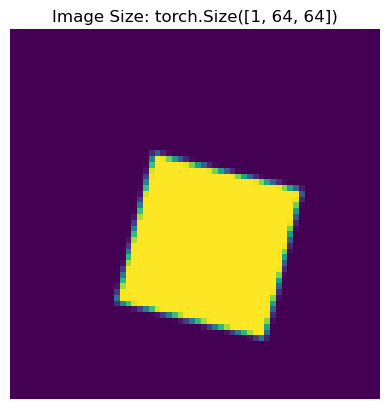

In [6]:
# Select an index
index_example = 7

# Get the item corresponding to the given index
image_tensor = training_dataset.__getitem__(index_example)

# Convert to NumPy format for plotting (0-1) -> (0-255)
image_np = F.to_pil_image(image_tensor)  # Convert back to PIL

# Plot the image
plt.imshow(image_np)
plt.axis("off")  # Hide axes
plt.title(f"Image Size: {image_tensor.size()}") # Plot the size of the tensor
plt.show()

Define the dataloaders from the CustomDataset:

In [7]:
# Size of each batch
batch_size = 10 

# Define 3 DataLoaders: Training/Validation/Test 
training_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

The model is defined as an **encoder** that finds a latent representation of the input and a **decoder** that reconstructs the input from the latent representation. The output of the combined model (*ImageAutoencoder*) is the reconstructed input, but the encoded (latent space) representation is the one usually used for classification/regression/etc.

In [8]:
class ImageAutoencoder(nn.Module):
    def __init__(self, latent_space_size=8):
        '''
        latent_space_size : (int) number of dimensions of the latent space
        '''
        
        super(ImageAutoencoder, self).__init__()

        # Encoder: Reduces image size and learns feature representations
        self.encoder = nn.Sequential(
            # Convolutional layer with stride > 1 to downsample the image
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),            # (1, 64, 64) → (16, 32, 32) - Downsample
            nn.ReLU(),
            
            # Convolutional layer with stride > 1 to downsample the image
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),           # (16, 32, 32) → (32, 16, 16) - Downsample
            nn.ReLU(),

            # Convolutional layer with stride > 1 to downsample the image
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),           # (32, 16, 16) → (64, 8, 8) - Downsample
            nn.ReLU(),

            # Convolutional layer with stride > 1 to downsample the image
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),          # (64, 8, 8) → (128, 4, 4) - Downsample
            nn.ReLU(),

            # Flatten layer to obtain R^(128*4*4) vector with dropout to improve training
            nn.Flatten(),
            nn.Dropout(0.2),

            # Linear layer to reduce the flattened vector to latent_space_size
            nn.Linear(128 * 4 * 4, latent_space_size)  
        )

        # Decoder: Reconstructs the original image from the latent space
        self.decoder = nn.Sequential(
            # Linear layer to expand from latent_space_size to the flattened vector size (128 * 4 * 4)
            nn.Linear(latent_space_size, 128 * 4 * 4),  
            #nn.ReLU(),
            
            # Unflatten from (128 *4 * 4) to a tensor (128, 4, 4) with dropout to improve training
            nn.Unflatten(1, (128, 4, 4)),
            nn.Dropout(0.2),

            # Pseudo-Inverse 2D Convolution with stride and output_padding to upsample
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # (128, 4, 4) → (64, 8, 8) - Upsample
            nn.ReLU(),

            # Pseudo-Inverse 2D Convolution with stride and output_padding to upsample
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),   # (64, 8, 8) → (32, 16, 16) - Upsample
            nn.ReLU(),

            # Pseudo-Inverse 2D Convolution with stride and output_padding to upsample
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),   # (32, 16, 16) → (16, 32, 32) - Upsample
            nn.ReLU(),

            # Pseudo-Inverse 2D Convolution with stride and output_padding to upsample
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),    # (16, 32, 32) → (1, 64, 64) - Upsample

            # Sigmoid output normalization to ensure tensor in the proper range [0,1]
            nn.Sigmoid()
        )


    
    # Forward method
    def forward(self, x):
        
        # Encode
        encoded = self.encoder(x)  
        # Decode
        decoded = self.decoder(encoded)  
        
        return decoded



# Initialize the model and move it to the device
model = ImageAutoencoder().to(device)

# Example input (assuming grayscale images of size 64x64)
x = torch.randn(1, 1, 64, 64).to(device)  # Batch size 1, 1 channel, 64x64 image
output = model(x)

print("Output shape:", output.shape)  # Expected: (1,1,64,64) - (Batch, channels, resolution, resolution)

Output shape: torch.Size([1, 1, 64, 64])


A possible loss for reconstruction is Mean Squared Error. When working with masks, Binary Cross Entropy (or Dice Loss) would be a better choice to ensure correct representation, but we used MSE for ease of generalisation.

In [9]:
# Loss function (Mean Squared Error):
loss_fn = nn.MSELoss() 

# Optimizer (Adam): 
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Training cycle:

In [10]:
# Number of training epochs:
n_epochs = 30

training_loss_list = []
validation_loss_list = []

# Iterate over the epochs:
for epoch in range(n_epochs):

    # Set the model to Training mode: This interacts with certain kind of network layers (such as Dropout layers)
    model.train()  

    # Temporary variable to store the loss on the whole epoch as a convergence metric
    running_loss = 0.0

    # Iterate on the whole dataset using the dataloader.
    for img_input_tmp in training_dataloader:
        # Load inputs ad move to device (GPU)
        img_input_tmp = img_input_tmp.to(device)

        # Clear previous gradients
        optimizer.zero_grad()  
        
        # Forward pass (model calls)
        img_output_tmp = model(img_input_tmp)  

        # Compute loss 
        loss = loss_fn(img_output_tmp, img_input_tmp)  
        
        # Backpropagation 
        loss.backward()  

        # Update parameters (optimization step)
        optimizer.step()  

        # Update running loss as convergence metric
        running_loss += loss.item()
        

    
    ## Calculate loss on validation as an additional metric to evaluate overfitting
    # Set the model to Evaluation mode:
    model.eval()

    # Temporary variable to store the validation loss:
    running_val_loss = 0.0
    
    # Deactivate gradient computation
    with torch.no_grad():
        for img_input_tmp in validation_dataloader:
            # Load inputs ad move to device (GPU)
            img_input_tmp = img_input_tmp.to(device)

            # Forward pass (model calls)
            img_output_tmp = model(img_input_tmp)

            # Compute loss 
            loss = loss_fn(img_output_tmp, img_input_tmp)

            # Update validation running loss as convergence metric
            running_val_loss += loss.item()
            
    # Average epoch loss
    epoch_training_loss = running_loss / len(training_dataloader)
    epoch_validation_loss = running_val_loss / len(validation_dataloader)

    # Append the losses to the list:
    training_loss_list.append(epoch_training_loss)
    validation_loss_list.append(epoch_validation_loss)

    # Convergence metric
    print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {epoch_training_loss:.4f}, Val. Loss: {epoch_validation_loss:.4f}")

Epoch [1/30], Loss: 0.0404, Val. Loss: 0.0156
Epoch [2/30], Loss: 0.0160, Val. Loss: 0.0138
Epoch [3/30], Loss: 0.0126, Val. Loss: 0.0091
Epoch [4/30], Loss: 0.0087, Val. Loss: 0.0055
Epoch [5/30], Loss: 0.0068, Val. Loss: 0.0039
Epoch [6/30], Loss: 0.0058, Val. Loss: 0.0043
Epoch [7/30], Loss: 0.0052, Val. Loss: 0.0037
Epoch [8/30], Loss: 0.0048, Val. Loss: 0.0030
Epoch [9/30], Loss: 0.0045, Val. Loss: 0.0030
Epoch [10/30], Loss: 0.0043, Val. Loss: 0.0025
Epoch [11/30], Loss: 0.0041, Val. Loss: 0.0026
Epoch [12/30], Loss: 0.0039, Val. Loss: 0.0026
Epoch [13/30], Loss: 0.0037, Val. Loss: 0.0019
Epoch [14/30], Loss: 0.0036, Val. Loss: 0.0023
Epoch [15/30], Loss: 0.0036, Val. Loss: 0.0022
Epoch [16/30], Loss: 0.0035, Val. Loss: 0.0021
Epoch [17/30], Loss: 0.0034, Val. Loss: 0.0019
Epoch [18/30], Loss: 0.0033, Val. Loss: 0.0019
Epoch [19/30], Loss: 0.0032, Val. Loss: 0.0020
Epoch [20/30], Loss: 0.0032, Val. Loss: 0.0017
Epoch [21/30], Loss: 0.0032, Val. Loss: 0.0018
Epoch [22/30], Loss: 0

Plots the convergence curves (Training and Validation losses):

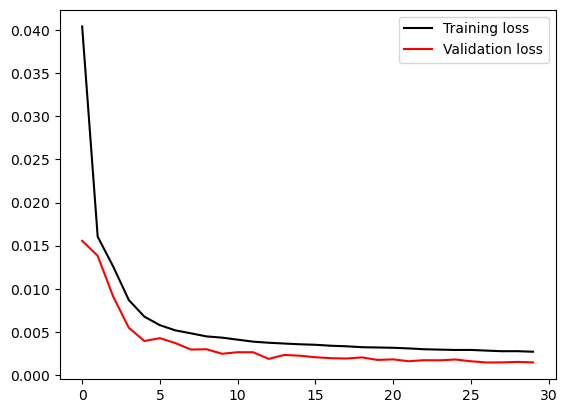

In [11]:
fig, ax = plt.subplots()

ax.plot(list(range(len(training_loss_list))), training_loss_list, color = 'black', label='Training loss')
ax.plot(list(range(len(validation_loss_list))), validation_loss_list,  color = 'red', label='Validation loss')
ax.legend()

We can plot a random reconstruction from the training/validation/test sets. We also plot the image with a cutoff (0.5) to obtain a candidate mask.

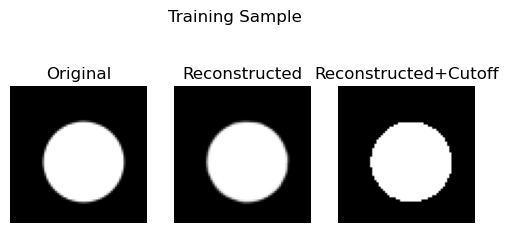

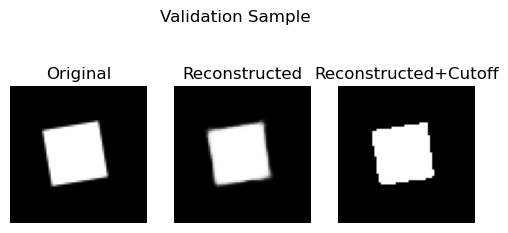

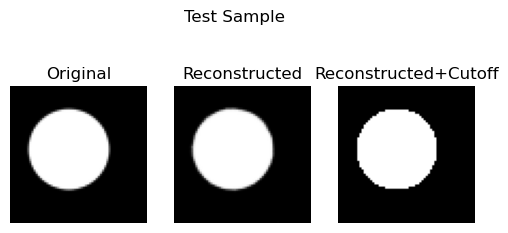

In [12]:
# Aux function to plot the results
def plot_autoencoder_results(model, dataloader, title, device):
    # Set model to evaluation mode
    model.eval()

    # Select a random batch and pick one image
    with torch.no_grad():
        # Get a random index
        random_idx = random.randint(0, len(dataloader.dataset) - 1)
        
        # Fetch the corresponding image
        img_input = dataloader.dataset[random_idx].unsqueeze(0).to(device)  # Add batch dim

        # Forward pass (get reconstructed image)
        img_output = model(img_input)

    # Convert tensors to NumPy for plotting
    img_input_np = img_input.squeeze(0).cpu().numpy().transpose(1, 2, 0)  # [C, H, W] → [H, W, C]
    img_output_np = img_output.squeeze(0).cpu().numpy().transpose(1, 2, 0) 
    
    # Plot the original and reconstructed images
    fig, axes = plt.subplots(1, 3, figsize=(6, 3))

    # Original
    axes[0].imshow(img_input_np, cmap="gray")  
    axes[0].set_title("Original")
    axes[0].axis("off")

    # Reconstructed
    axes[1].imshow(img_output_np, cmap="gray")  
    axes[1].set_title("Reconstructed")
    axes[1].axis("off")

    # Define a cutoff 0.5
    img_output_np_cutoff = img_output_np
    img_output_np_cutoff[img_output_np_cutoff>0.5] = 1
    img_output_np_cutoff[img_output_np_cutoff<=0.5] = 0

    # Reconstructed and cutoff
    axes[2].imshow(img_output_np_cutoff, cmap="gray")  
    axes[2].set_title("Reconstructed+Cutoff")
    axes[2].axis("off")

    plt.suptitle(title)
    plt.show()

# Run a random visualization for each dataset
plot_autoencoder_results(model, training_dataloader, "Training Sample", device)
plot_autoencoder_results(model, validation_dataloader, "Validation Sample", device)
plot_autoencoder_results(model, test_dataloader, "Test Sample", device)

The encoding part provides a useful representation of the images in a low-dimensional space:

Latent representation: tensor([[ -5.6984,   4.1505, -13.3762,  14.5040, -10.7482,  -3.6558,   8.8344,
          -9.0007]], device='cuda:0', grad_fn=<AddmmBackward0>)


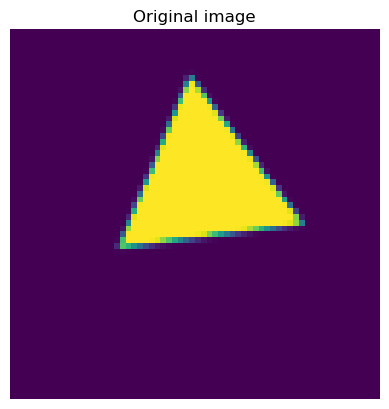

In [13]:
# Select an index
index_example = 27

# Set the model one evaluation:
model.eval()

# Get the item corresponding to the given index
image_tensor = validation_dataset.__getitem__(index_example).unsqueeze(0).to(device)  # Add batch dim and move to device

# Compute the latent representation
latent_representation = model.encoder(image_tensor)
print("Latent representation:", latent_representation)

# Image corresponding to the latent representation
image_np = F.to_pil_image(validation_dataset.__getitem__(index_example))  

# Plot the image
plt.imshow(image_np)
plt.axis("off")  # Hide axes
plt.title(f"Original image") 
plt.show()

Conversely, the decoder can be used to generate images from an input latent representation:

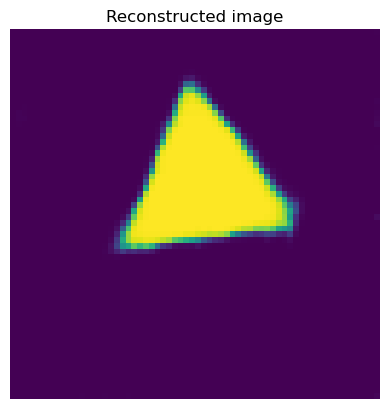

In [19]:
# Define a latent representation:
latent_representation = torch.tensor([[ -5.6984,   4.1505, -13.3762,  14.5040, -10.7482,  -3.6558,   8.8344, -9.0007]]).to(device)

# Set the model one evaluation:
model.eval()

img_output = model.decoder(latent_representation)
img_output_np = img_output.squeeze(0).cpu().detach().numpy().transpose(1, 2, 0) 

# Image corresponding to the latent representation
image_np = F.to_pil_image(img_output_np)  

# Plot the image
plt.imshow(image_np)
plt.axis("off")  # Hide axes
plt.title(f"Reconstructed image") 
plt.show()